<a href="https://colab.research.google.com/github/naminorigorilla/image_processing/blob/main/fish_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split 
import glob
from pathlib import Path
import re

import PIL
import torch
import torch.optim as optim
from torch import nn as nn
from torchvision import transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

! pip install torchinfo
from torchinfo import summary
import torch.nn.functional as F


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/Fish_Dataset/Fish_Dataset/"
df_image = pd.read_pickle(data_dir+ 'df_image.pkl')
df_image.head()

,path,label,_label
0,/content/drive/MyDrive/Fish_Dataset/Fish_Datas...,Hourse Mackerel,0
1,/content/drive/MyDrive/Fish_Dataset/Fish_Datas...,Hourse Mackerel,0
2,/content/drive/MyDrive/Fish_Dataset/Fish_Datas...,Hourse Mackerel,0
3,/content/drive/MyDrive/Fish_Dataset/Fish_Datas...,Hourse Mackerel,0
4,/content/drive/MyDrive/Fish_Dataset/Fish_Datas...,Hourse Mackerel,0


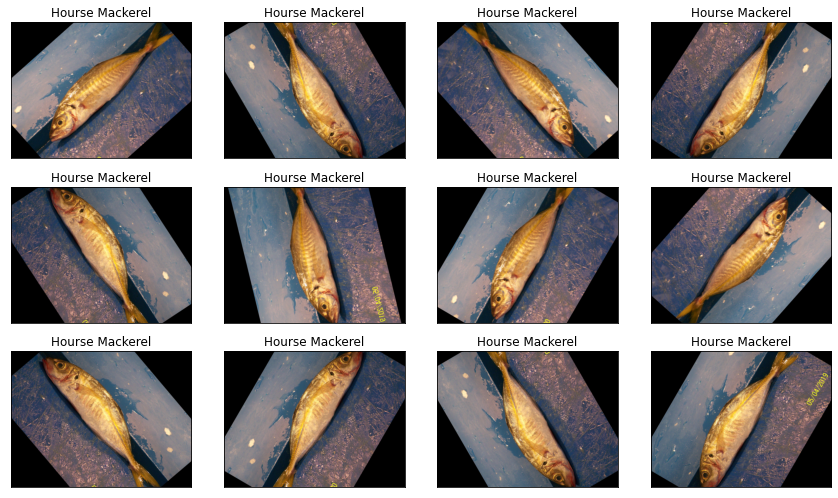

In [ ]:
# fig, axes = plt.subplots(3, 4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
# for idx, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(df_image.path[idx]))
#     ax.set_title(df_image.label[idx])
# plt.tight_layout()
# plt.show()

In [ ]:
#ラベルの数字化
fish_number = {
 'Hourse Mackerel': 0,
 'Black Sea Sprat': 1,
 'Sea Bass': 2,
 'Red Mullet': 3,
 'Trout': 4,
 'Striped Red Mullet': 5,
 'Shrimp': 6,
 'Gilt-Head Bream': 7,
 'Red Sea Bream': 8
}

In [ ]:
class Fish_Dataset(Dataset):
  def __init__(self,dataframe,transform):
    self.path = dataframe["path"]
    self.label = dataframe["_label"]
    self.transform = transform

  def __len__(self):
    #学習データの行を返す
    return len(self.path)

  def __getitem__(self,index):
#pathlib型はglob.globしなくていい
    image = self.path.values[index]
    image = Image.open(image)

    image = self.transform(image)
    label = self.label.values[index]
        
    return image,label

In [ ]:
# test = glob.glob(path + '/*/*/*.png')[0]
# test_image = Image.open(test)
# yimage=transforms.functional.to_tensor(test_image)
# print(yimage)

In [ ]:
df_image.label.nunique()

9

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Resize((32,32)),
     transforms.Normalize((0.5,),(0.5,))]
     )
dataset = Fish_Dataset(df_image,transform)

# シード値を固定
torch.manual_seed(42)
#学習データとテストデータに分割

from torchvision import datasets
#学習データに使用する割合
n_train_ratio = 0.8
#バッチサイズ
batch_size = 128

train_size = int(len(dataset)*n_train_ratio)
val_size = int(len(dataset) - train_size)
train,val = torch.utils.data.random_split(dataset,[train_size,val_size])

train_loader = torch.utils.data.DataLoader(train,batch_size = batch_size,shuffle = True,drop_last = True)
val_loader = torch.utils.data.DataLoader(val,batch_size = batch_size,shuffle = False)

In [ ]:
#元の画像データのサイズ
img = Image.open(df_image.path[0])
width,height = img.size
print('width:',width)
print('height:',height)

#テンソル変換後のサイズ
img_t = transform(img)
print(img_t.shape)

width: 590
height: 445
torch.Size([3, 32, 32])


In [ ]:
#next()でリストの要素を順番に取り出すと、バッチサイズ128、チャネル数3、32×32の画像のデータであることがわかる
a = next(iter(train_loader))
print(a[0].size())
print(a[1])

torch.Size([128, 3, 32, 32])
tensor([1, 0, 4, 5, 0, 6, 1, 6, 7, 4, 4, 4, 2, 5, 8, 5, 4, 6, 5, 2, 0, 0, 8, 0,
        0, 5, 3, 6, 0, 4, 5, 2, 8, 2, 0, 7, 3, 8, 3, 2, 3, 6, 0, 0, 7, 3, 5, 6,
        8, 0, 7, 5, 7, 1, 8, 1, 4, 6, 8, 7, 2, 2, 0, 5, 1, 2, 7, 0, 4, 4, 6, 3,
        2, 1, 4, 1, 3, 3, 4, 0, 4, 7, 3, 0, 8, 3, 5, 7, 2, 3, 2, 3, 1, 5, 4, 2,
        5, 2, 6, 0, 4, 6, 5, 5, 3, 1, 8, 6, 1, 4, 8, 0, 8, 6, 0, 8, 2, 4, 5, 0,
        5, 5, 6, 2, 5, 7, 2, 7])


In [ ]:
len(train_loader.dataset)

7214

In [ ]:
print(len(train_loader))
print(len(val_loader))

56
15


In [ ]:
cnt = 0
for data in train_loader:
  print(data[0].shape)
  cnt += 1
  if cnt == 3:
    break

torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])


In [ ]:
#ニューラルネットワーククラス
#torch.nn.Moduleによるモデルの定義
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,6,3)
    self.conv2 = nn.Conv2d(6,16,3)

    self.pool = torch.nn.MaxPool2d(2, 2)


  
    self.fc1 = torch.nn.Linear(16*6*6,60)
    self.fc2 = torch.nn.Linear(60,9)
    
    
  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = self.pool(x)
   
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = x.view(x.size()[0], -1)
    # x = x.view(-1, self.num_flat_features(x))
  
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [ ]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=9, bias=True)
)


In [ ]:
 net = net.to("cuda:0")

In [ ]:
from torchsummary import summary
model = net
summary(model,(3,32,32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
         MaxPool2d-2            [-1, 6, 15, 15]               0
            Conv2d-3           [-1, 16, 13, 13]             880
         MaxPool2d-4             [-1, 16, 6, 6]               0
            Linear-5                   [-1, 60]          34,620
            Linear-6                    [-1, 9]             549
Total params: 36,217
Trainable params: 36,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.14
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
net = net.to(DEVICE)

In [ ]:
def train(net,dataloader,criterion,optimizer):
  net.train()

  total_loss = 0.0
  total_correct = 0


  for inputs,labels in dataloader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)

    optimizer.zero_grad()
    outputs= net(inputs)

    loss = criterion(outputs,labels)
    loss.backward()

    optimizer.step()

    total_loss += loss.item()
    #torch.max は最大値とその位置の両方を返すので、不要な最大値は適当な変数名になっている
    _,predicted = torch.max(outputs,1)
    total_correct += (predicted == labels).sum().item()


  train_loss = total_loss/len(dataloader.dataset)
  train_accuracy = total_correct/len(dataloader.dataset)

  return train_loss,train_accuracy

In [ ]:
train_loader
 

In [ ]:
def validate(net,dataloader,criterion):
  net.eval()
#with文：一定期間だけオブジェクトを使用したりする場合に使う。
  with torch.no_grad():
    total_loss = 0.0
    total_correct = 0

    for inputs,labels in dataloader:
      inputs = inputs.to(device=DEVICE)
      labels = labels.to(device=DEVICE)

      outputs = net(inputs)
      loss = criterion(outputs,labels)

      total_loss += loss.item()
      _,predicted = torch.max(outputs,1)
      total_correct += (predicted == labels).sum().item()


    valid_loss = total_loss /len(dataloader.dataset)
    valid_accuracy = total_correct/len(dataloader.dataset)


    return valid_loss,valid_accuracy

In [ ]:
import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 20

history = {}
history['train_loss_values'] = []
history['train_accuracy_values'] = []
history['valid_loss_values'] = []
history['valid_accuracy_values'] = []


start = time.time()

for epoch in range(1, EPOCHS + 1):
  print(f'epoch: {epoch:2}')

  train_loss,train_accuracy = train(net, train_loader, criterion, optimizer)
  valid_loss,valid_accuracy = validate(net,val_loader,criterion)
  # validate(net, val_loader, criterion)

  history['train_loss_values'].append(train_loss)
  history['train_accuracy_values'].append(train_accuracy)
  history['valid_loss_values'].append(valid_loss)
  history['valid_accuracy_values'].append(valid_accuracy)

  print(f'train_loss: {train_loss:.6f}, train_accuracy: {train_accuracy:3.4%}',
        f'valid_loss: {valid_loss:.6f}, valid_accuracy: {valid_accuracy:3.4%}')

end = time.time()

print(f'{end - start:.6}')

epoch:  1
train_loss: 0.017067, train_accuracy: 13.4461% valid_loss: 0.018275, valid_accuracy: 15.4102%
epoch:  2
train_loss: 0.017018, train_accuracy: 16.4403% valid_loss: 0.018231, valid_accuracy: 17.1286%
epoch:  3
train_loss: 0.016977, train_accuracy: 18.2839% valid_loss: 0.018187, valid_accuracy: 19.5122%
epoch:  4
train_loss: 0.016932, train_accuracy: 19.6285% valid_loss: 0.018132, valid_accuracy: 20.5100%
epoch:  5
train_loss: 0.016876, train_accuracy: 21.4860% valid_loss: 0.018064, valid_accuracy: 23.8914%
epoch:  6
train_loss: 0.016803, train_accuracy: 24.6465% valid_loss: 0.017976, valid_accuracy: 25.7206%
epoch:  7
train_loss: 0.016705, train_accuracy: 26.7119% valid_loss: 0.017851, valid_accuracy: 27.2727%
epoch:  8
train_loss: 0.016562, train_accuracy: 28.1259% valid_loss: 0.017659, valid_accuracy: 30.1552%
epoch:  9
train_loss: 0.016339, train_accuracy: 29.5952% valid_loss: 0.017363, valid_accuracy: 31.4302%
epoch: 10
train_loss: 0.015980, train_accuracy: 31.8547% valid_l

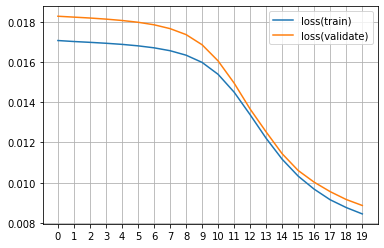

In [ ]:
def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.xticks(np.arange(0, 20, step=1))
    plt.legend()
    plt.grid()
    plt.show()

t_losses = history['train_loss_values']
t_accus = history['train_accuracy_values']
v_losses = history['valid_loss_values']
v_accus = history['valid_accuracy_values']

plot_graph(t_losses, v_losses, EPOCHS, 'loss(train)', 'loss(validate)')

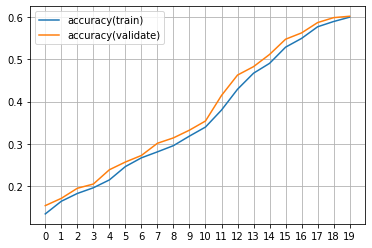

In [ ]:
plot_graph(t_accus,v_accus,EPOCHS,'accuracy(train)','accuracy(validate)')